# Fit piecewise linear regression
includes both activity in last 30 days and historical features

Explore data distributions and ways to normalize

In [ ]:
from glob import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ols_functions as of
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import psycopg2
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['figure.facecolor'] = 'white'

## Data processing

###  Load all data--this takes a while

In [65]:
indices = allX.reset_index()[['handle', 'contestid']]
indices.to_csv('OLStrain_all_normalized_data_index.csv', header=True, index=False)

In [66]:
#reload(of)
#allX, allY = of.get_train_val_test()

In [67]:
max(allY)

532.75

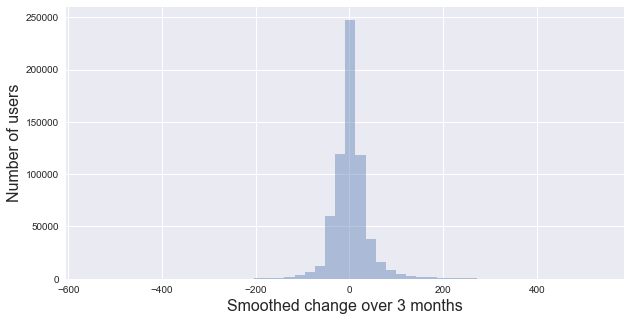

In [68]:
plt.rcParams['figure.figsize'] = (10, 5)
sns.distplot(allY, kde=False)
plt.xlabel('Smoothed change over 3 months', fontsize=16)
plt.ylabel('Number of users', fontsize=16)

In [122]:
dropcols = ['rating_change_smooth', 'rating_change', 'user_rating_smooth', 'contesttime', 'oldrating', 'user_rating']
for d in dropcols:
    if d in allX.columns:
        allX.drop(d, axis=1, inplace=True)

In [123]:
for c in allX.columns:
    print c

drdt
java
lowlevel
max_error_contest
max_error_practice
max_probability_contest
max_probability_practice
max_ratingdiff_contest
max_ratingdiff_practice
max_solvetime
max_timediff
max_wrong_contest
max_wrong_practice
mean_error_contest
mean_error_practice
mean_probability_contest
mean_probability_practice
mean_ratingdiff_contest
mean_ratingdiff_practice
mean_solvetime
mean_timediff
mean_wrong_contest
mean_wrong_practice
min_solvetime
min_timediff
n100
n200
n300
n400
n500
n_solved
n_unlikely01
n_unlikely02
performance
python
rank
smoothed_3months
std_error_contest
std_error_practice
std_probability_contest
std_probability_practice
std_ratingdiff_contest 
std_ratingdiff_practice
std_solvetime
std_timediff
std_wrong_contest
std_wrong_practice
tot_solvetime
total_contests
total_error_contest
total_error_practice
total_newtags
total_problems
total_wrong_contest
total_wrong_practice
unique_newtags
unique_tags_total
*special
2-sat
binary search
bitmasks
brute force
chinese remainder theorem
co

In [124]:
allX.shape

(646441, 105)

### Load train/val/test sets

In [4]:
with open('set_train.txt') as f:
    settrain = [t.strip() for t in f.readlines()]
with open('set_test.txt') as f:
    settest = [t.strip() for t in f.readlines()]
with open('set_val.txt') as f:
    setval = [t.strip() for t in f.readlines()]

In [126]:
print len(settrain)
print len(setval)
print len(settest)

37679
9420
11775


In [128]:
print allX.loc[settrain].shape
print allX.loc[settest].shape
print allX.loc[setval].shape

(287011, 105)
(123932, 105)
(90826, 105)


### Apply transformations to ```X```, fill in missing values

In [129]:
allX.columns.values[np.any(allX==-1, axis=0)]

array([], dtype=object)

#### Normalize solve times for problems that were never solved

In [75]:
idx_missing = (allX.max_solvetime == -1)
allX.loc[idx_missing, 'max_solvetime'] = -max(allX.max_solvetime)

idx_missing = (allX.mean_solvetime == -1)
allX.loc[idx_missing, 'mean_solvetime'] = -max(allX.mean_solvetime)

idx_missing = (allX.min_solvetime == -1)
allX.loc[idx_missing, 'min_solvetime'] = -max(allX.min_solvetime)

idx_missing = (allX.tot_solvetime == -1)
allX.loc[idx_missing, 'tot_solvetime'] = -max(allX.tot_solvetime)

#### fill nas

In [76]:
allXfill = allX.fillna(value=0)

#### Clip arbitrarily large values

##### Time variables

In [77]:
[(a, max(allXfill[a])) for a in allXfill.columns if 'time' in a]

[('max_solvetime', 5962.4816666699999),
 ('max_timediff', 2399.0636342600001),
 ('mean_solvetime', 2515.89722222),
 ('mean_timediff', 1694.9608564800001),
 ('min_solvetime', 2515.89722222),
 ('min_timediff', 1694.9608564800001),
 ('std_solvetime', 2086.55064287),
 ('std_timediff', 1199.5266666699999),
 ('tot_solvetime', 5960.4816666699999),
 ('time_between_mean', 2585066.0),
 ('time_between_std', 1291065.5)]

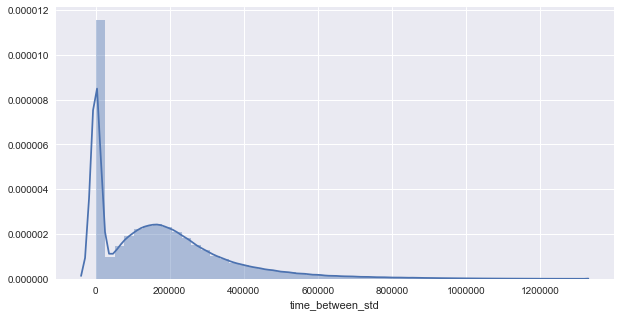

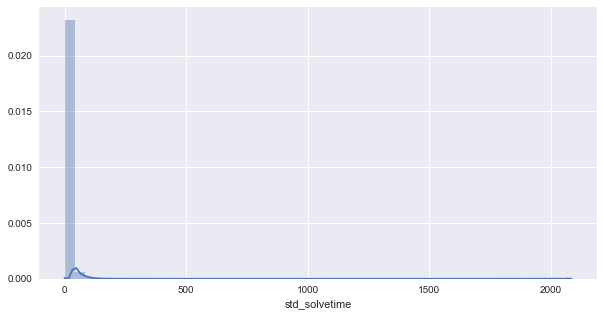

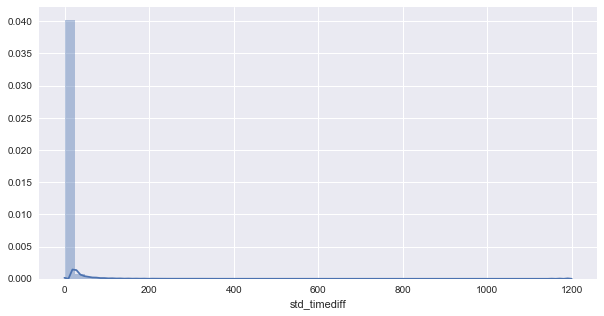

In [78]:
plt.rcParams['figure.figsize'] = (5, 3)
sns.distplot(allXfill.time_between_std)
plt.figure()
sns.distplot(allXfill.std_solvetime)
plt.figure()
sns.distplot(allXfill.std_timediff)

In [79]:
allXfill['time_between_std'] = np.clip(allXfill['time_between_std'], 0, 800000) 
allXfill['std_solvetime'] = np.clip(allXfill['std_solvetime'], 0, 100) 
allXfill['std_timediff'] = np.clip(allXfill['std_timediff'], 0, 100) 

(0, 2000)

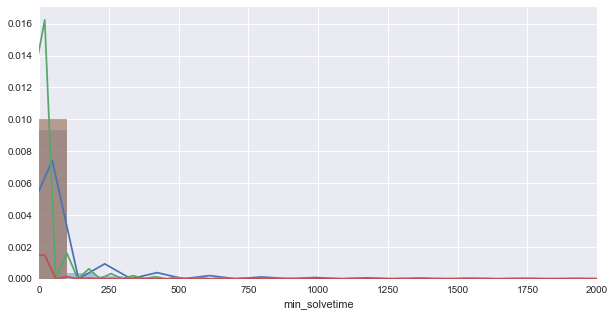

In [80]:
sns.distplot(allXfill.max_solvetime, bins=[0, 100, 200, 300, 400, 500])
sns.distplot(allXfill.mean_solvetime, bins=[0, 100, 200, 300, 400, 500])
sns.distplot(allXfill.min_solvetime, bins=[0, 100, 200, 300, 400, 500])
plt.xlim([0, 2000])

In [81]:
allXfill['max_solvetime'] = np.clip(allXfill['max_solvetime'], 0, 500) 
allXfill['mean_solvetime'] = np.clip(allXfill['mean_solvetime'], 0, 500) 
allXfill['min_solvetime'] = np.clip(allXfill['min_solvetime'], 0, 500) 

(0, 2000)

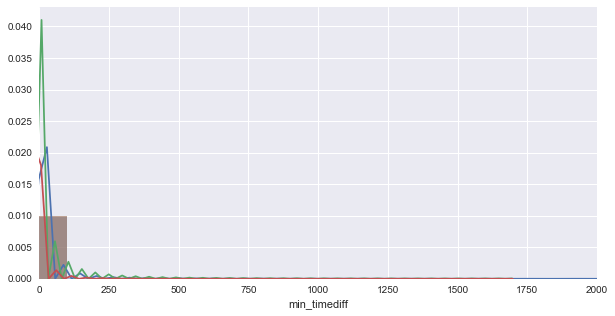

In [82]:
sns.distplot(allXfill.max_timediff, bins=[0, 100, 200, 300, 400, 500])
sns.distplot(allXfill.mean_timediff, bins=[0, 100, 200, 300, 400, 500])
sns.distplot(allXfill.min_timediff, bins=[0, 100, 200, 300, 400, 500])
plt.xlim([0, 2000])


In [83]:
allXfill['max_timediff'] = np.clip(allXfill['max_timediff'], 0, 500) 
allXfill['mean_timediff'] = np.clip(allXfill['mean_timediff'], 0, 500) 
allXfill['min_timediff'] = np.clip(allXfill['min_timediff'], 0, 500) 

(0, 2000)

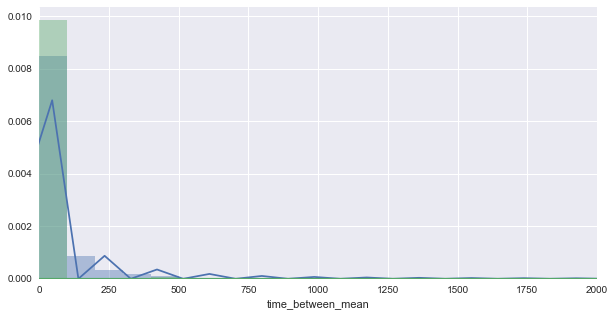

In [84]:
sns.distplot(allXfill.tot_solvetime, bins=[0, 100, 200, 300, 400, 500])
sns.distplot(allXfill.time_between_mean, bins=[0, 100, 200, 300, 400, 500])
plt.xlim([0, 2000])

In [85]:
allXfill['tot_solvetime'] = np.clip(allXfill['tot_solvetime'], 0, 500) 
allXfill['time_between_mean'] = np.clip(allXfill['time_between_mean'], 0, 500) 

##### Rating variables

These actualy look ok, skip clipping for now

In [86]:
[(a, max(allXfill[a])) for a in allXfill.columns if 'rating' in a]

[('max_ratingdiff_contest', 4108.25),
 ('max_ratingdiff_practice', 4335.8888888900001),
 ('mean_ratingdiff_contest', 3789.1999999999998),
 ('mean_ratingdiff_practice', 3934.75),
 ('oldrating', 3739),
 ('std_ratingdiff_contest ', 2151.4677677200002),
 ('std_ratingdiff_practice', 2500.5),
 ('rating_diff_mean', 3900.5999999999999),
 ('rating_diff_std', 2087.0),
 ('user_rating', 3739.0)]

(0, 2000)

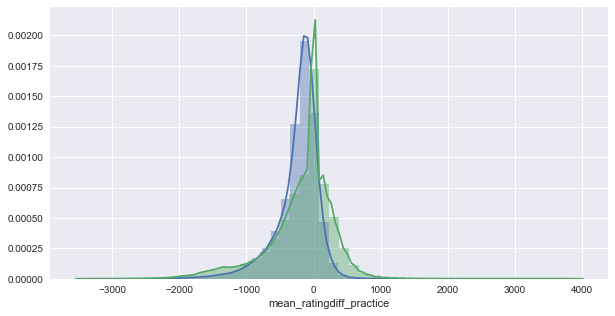

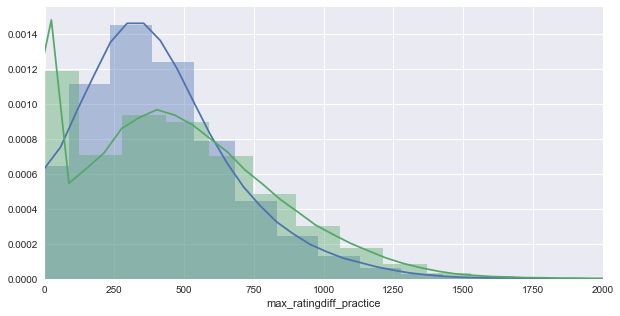

In [87]:
#sns.distplot(allXfill.rating_diff_mean)
sns.distplot(allXfill.mean_ratingdiff_contest)
sns.distplot(allXfill.mean_ratingdiff_practice)
plt.figure()
sns.distplot(allXfill.max_ratingdiff_contest)
sns.distplot(allXfill.max_ratingdiff_practice)
#plt.legend([
#    'Mean rating difference, contest',
#    'Mean rating difference, practice',
#    'Max rating difference, contest',
#    'Max rating difference, practice',
#           ])
plt.xlim([0, 2000])

#### Normalize rating differences were problem ratings were unavailable

best way is probably to just set them to zero.

In [88]:
idx_missing = (allX.max_ratingdiff_contest== -1)
allX.loc[idx_missing, 'max_ratingdiff_contest'] = 0

idx_missing = (allX.max_ratingdiff_practice== -1)
allX.loc[idx_missing, 'max_ratingdiff_practice'] = 0

idx_missing = (allX.mean_ratingdiff_contest== -1)
allX.loc[idx_missing, 'mean_ratingdiff_contest'] = 0

idx_missing = (allX.mean_ratingdiff_practice== -1)
allX.loc[idx_missing, 'mean_ratingdiff_practice'] = 0

idx_missing = (allX.rating_diff_mean == -1)
allX.loc[idx_missing, 'rating_diff_mean'] = 0

### take log of likelihoods

In [89]:
[(a, max(allXfill[a])) for a in allXfill.columns if 'probability' in a]

[('max_probability_contest', 0.99999999871199996),
 ('max_probability_practice', 0.9999999984739999),
 ('mean_probability_contest', 0.99999999550699992),
 ('mean_probability_practice', 0.999999997862),
 ('std_probability_contest', 0.49971727953400003),
 ('std_probability_practice', 0.49999940017899996)]

Looks like there's some issues with the mins... just remove them

In [93]:
dropcols = ['min_probability_contest', 'min_probability_practice']
for d in dropcols:
    if d in allXfill.columns:
        allXfill.drop(d, axis=1, inplace=True)

In [94]:
pcols =  [a for a in allXfill.columns if 'probability' in a]
for a in pcols:
    newname = "log_" + a
    allXfill.loc[allXfill[a] == 0, a] = 1e-20
    allXfill[newname] = np.log(allXfill[a])


In [95]:
xmax = np.max(allXfill, axis=0)
xcolnames = xmax.index

In [96]:
for a, b in zip(xmax, xcolnames):
    print a, b

11.42857143 drdt
1.0 java
1.0 lowlevel
62.0 max_error_contest
45.0 max_error_practice
0.999999998712 max_probability_contest
0.999999998474 max_probability_practice
4108.25 max_ratingdiff_contest
4335.88888889 max_ratingdiff_practice
500.0 max_solvetime
500.0 max_timediff
164.0 max_wrong_contest
221.0 max_wrong_practice
14.0 mean_error_contest
45.0 mean_error_practice
0.999999995507 mean_probability_contest
0.999999997862 mean_probability_practice
3789.2 mean_ratingdiff_contest
3934.75 mean_ratingdiff_practice
500.0 mean_solvetime
500.0 mean_timediff
51.6666666667 mean_wrong_contest
83.0 mean_wrong_practice
500.0 min_solvetime
500.0 min_timediff
226.0 n100
209.0 n200
188.0 n300
174.0 n400
162.0 n500
732.0 n_solved
178.0 n_unlikely01
201.0 n_unlikely02
3739.0 oldrating
1.0 performance
1.0 python
6550.0 rank
3665.5 smoothed_3months
18.4 std_error_contest
20.7578633026 std_error_practice
0.499717279534 std_probability_contest
0.499999400179 std_probability_practice
2151.46776772 std_ratin

###  Max normalization

In [97]:
allXnorm = allXfill / xmax

### Normalize rating changes

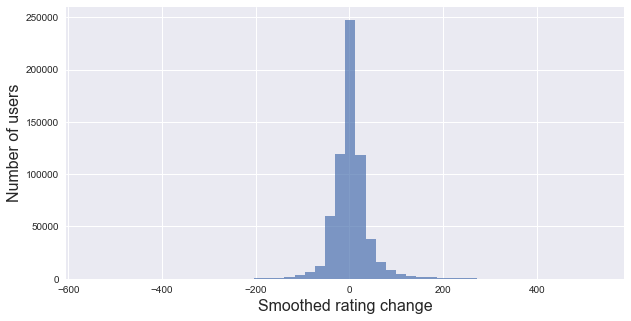

In [130]:
sns.distplot(allY, kde=False, hist_kws={"alpha": .7})
plt.xlabel('Smoothed rating change', fontsize=16)
plt.ylabel('Number of users', fontsize=16)
pp = PdfPages('fig_rating_change_dist.pdf')
pp.savefig()
pp.close()

In [110]:
allXnorm['yval'] = allY / max(allY)

In [111]:
max(allY)

532.75

### New features

In [118]:
allXnorm['mod_perf'] = allXnorm.drdt * allXnorm.performance

In [ ]:
# Exponential
for c in allXnorm.columns:
    if "yval" not in c:
        colname = "exp_" + c
        coeff = max(allXnorm[c])
        allXnorm[colname] = np.exp(allXnorm[c] / coeff)

# Tanh
for c in allXnorm.columns:
    if "exp" not in c and "yval" not in c:
        colname = "tanh_" + c
        allXnorm[colname] = np.tanh(allXnorm[c])
   

In [ ]:
# inverse
for c in allXnorm.columns:
    if "exp" not in c and "yval" not in c and "tanh" not in c:
        colname = "inv_" + c
        allXnorm[colname] = allXnorm[c]
        not_zeros = allXnorm[colname] != 0
        allXnorm.loc[not_zeros, colname] = 1.0 / allXnorm.loc[not_zeros, colname]
        
allXnorm['bias'] = 1

### Create bins

In [ ]:
q, qbins = pd.qcut(allXnorm.smoothed_3months, 20, retbins=True)
allXnorm['q'] = q

## Save output to csv

In [ ]:
allXnorm.to_csv('OLStrain_all_normalized_data.csv', header=True, index=True)

In [2]:
allXnorm = pd.read_csv('OLStrain_all_normalized_data.csv')

In [8]:
allXnorm_index = pd.read_csv('OLStrain_all_normalized_data_index.csv')

In [12]:
allXnorm = pd.concat([allXnorm, allXnorm_index], axis=1)

In [14]:
allXnorm.set_index('handle', inplace=True)

## Elastic net

```
ElasticNetCV(l1_ratio=0.5, eps=0.001, n_alphas=100, alphas=None,
#fit_intercept=True, normalize=False, precompute='auto', max_iter=1000,
#tol=0.0001, cv=None, copy_X=True, verbose=0, n_jobs=1, positive=False,
#random_state=None, selection='cyclic')
```

In [15]:
allXnorm.shape

(646441, 458)

In [ ]:
Xtrain = allXnorm.loc[settrain + setval]
Xtest = allXnorm.loc[settest]

In [ ]:
Ytrain = Xtrain.yval

In [ ]:
l1s = [.5, .7, .9, .95, .99, 1]
alphas = np.arange(0.0001, .001, 1e-4)

In [ ]:
xmax = np.max(np.array(allXnorm), axis=0)
xcolnames = allXnorm.columns
xmax = xmax[ [i for i in range(len(xcolnames)) if xcolnames[i] not in ['yval', 'q', 'q2'] ] ]

In [ ]:
xmax = np.array([float(x) for x in xmax])

In [ ]:
models1 = []
cnt = 0
for k, xin in Xtrain.groupby('q'):
    xin.is_copy = False

    yin = xin['yval']
    xin.drop(['yval', 'q', 'q2'], axis=1, inplace = True)
    xin = np.array(xin)
    xin = xin/ xmax
    xin[np.isnan(xin)] = 0
    
    en = ElasticNetCV(
        l1_ratio=l1s,
        eps=0.001,
        alphas=alphas,
        max_iter=10000,
        fit_intercept=True,
        cv=3,
        random_state=9,
        tol=0.00001
    )
    results = en.fit(xin, yin)
    models1.append(results)
    nvar = sum(results.coef_ != 0)
    rsq = results.score(xin, yin)
    print k, "%6d entries, ---------------> %f, %d variables" %(xin.shape[0], rsq, nvar)

In [ ]:
xtrain_in = []
ytrain_in = []
cnt = 0

for k, xin in Xtrain.groupby('q'):
    print k
    xin.is_copy = False

    yin = xin['yval']
    xin.drop(['yval', 'q', 'q2'], axis=1, inplace = True)
    xin = np.array(xin)
    xin /= xmax
    xin[np.isnan(xin)] = 0
    xtrain_in.append(xin)
    ytrain_in.append(yin)

In [ ]:
xtest_in = []
ytest_in = []
cnt = 0

for k, xin in Xtest.groupby('q'):
    print k
    xin.is_copy = False

    yin = xin['yval']
    xin.drop(['yval', 'q', 'q2'], axis=1, inplace = True)
    xin = np.array(xin)
    xin /= xmax
    xin[np.isnan(xin)] = 0
    xtest_in.append(xin)
    ytest_in.append(yin)

In [ ]:
for i in range(len(models)):
    print models[i].alpha_

In [841]:
r2_train = []
r2_test = []
for i in range(len(models1)):
    m = models1[i]
    ypred_train = m.predict(xtrain_in[i])
    ypred_test = m.predict(xtest_in[i])
    r2_train.append(r2_score(ytrain_in[i], ypred_train))
    r2_test.append(r2_score(ytest_in[i], ypred_test))

## Plotting $r^2$ values

In [914]:
con = psycopg2.connect(database='codeforces', user='Joy')
q = """
SELECT DISTINCT ON (handle) handle, newrating
FROM user_rating
ORDER BY handle, ratingupdatetimeseconds DESC
"""
last_usr_rating = pd.read_sql(q, con)

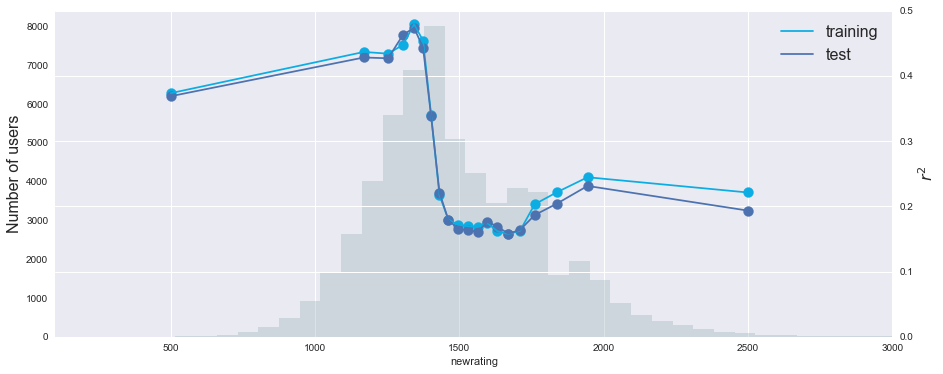

In [966]:

nbins = len(r2_train)
xax = map(int, qbins*3739)
xax_ticks = [str(xax[i]) + ' : ' + str(xax[i+1]) for i in range(len(xax)-1)]
xax = xax[0:-1]
xax[0] = 500
xax[-1] = 2500

plt.rcParams['figure.figsize'] = (15, 6)
fig, ax1 = plt.subplots()

sns.distplot(last_usr_rating.newrating, ax=ax1, kde=False, color="#A4B9BF")

ax2 = ax1.twinx()
ax2.plot(xax, r2_train, c="#0BADE3")
ax2.scatter(xax, r2_train, s=100, c="#0BADE3")
ax2.plot(xax, r2_test)
ax2.scatter(xax, r2_test, s=100)

ax1.set_xticks(xax[0:-1], xax_ticks)
plt.ylim(0, .5)

#plt.xticks(xax[0:-1], xax_ticks, rotation='vertical')

plt.xlabel('User bin', fontsize=16)
ax1.set_ylabel('Number of users', fontsize=16)
ax2.set_ylabel('$r^2$', fontsize=16)
ax1.yaxis.grid(False)

plt.xlim(100, 3000)
plt.legend(['training', 'test'], fontsize=16)
pp = PdfPages('r2_loss.pdf')
pp.savefig()
pp.close()

##  throw out all the variables that were never used

 There are a total of 119 unique variables that were non-0 in any model, although each model may have only ~60-80 non-0 variables at a time

In [967]:
param_idx = np.zeros( xtrain_in[0].shape[1] )
for i in range(len(models1)):
    m = models1[i]
    param_idx += (m.coef_ > 0)
param_idx = param_idx > 0

mat = np.zeros( [len(models1), sum(param_idx > 0) ] )
print mat.shape
for i in range(len(models1)):
    m = models1[i]
    mat[i, :] = m.coef_[param_idx]

(20, 119)


## plot all coefficients

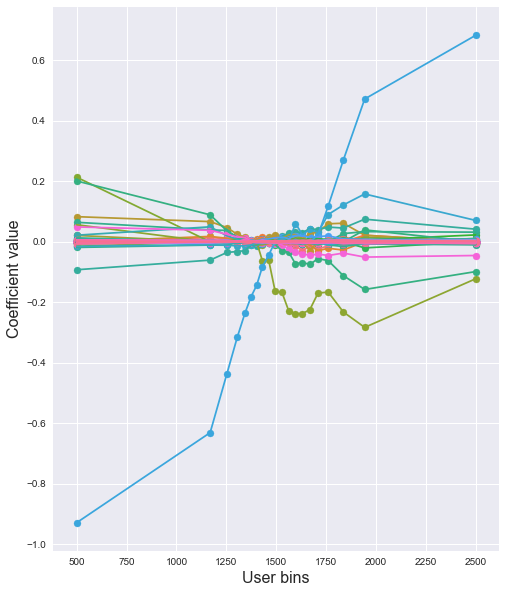

In [987]:
plt.rcParams['figure.figsize'] = (8, 10)
with sns.color_palette("husl", mat.shape[1]):
    for i in range(mat.shape[1]):
        plt.plot(xax, mat[:, i])
        plt.scatter(xax, mat[:, i])
plt.xlabel('User bins', fontsize = 16)
plt.ylabel('Coefficient value', fontsize = 16)
pp = PdfPages('coeff_vs_bins.pdf')
pp.savefig()
pp.close()
#plt.legend(varkeep.columns)

In [848]:
np.where(models1[0].coef_ == max(models1[0].coef_))
np.where(abs(models1[0].coef_) == max(np.abs(models1[0].coef_)))

(array([390]),)

In [849]:
print models1[0].coef_[265]
print models1[0].coef_[390]

0.213614145081
-0.929144162173


In [988]:
xcolnameskeep =  [x for x in xcolnames if x not in ['yval', 'q', 'q2'] ] 

In [989]:
print xcolnameskeep[265]
print xcolnameskeep[390]

tanh_smoothed_3months
inv_total_contests


In [993]:
varkeep = pd.DataFrame(mat)
varkeep.columns = np.array(xcolnameskeep)[param_idx]
a = np.max(varkeep, axis=0)
b = a.index
sig_colnames = sorted(zip(b, a), key=lambda x: np.abs(x[1]))[-20: len(a)]

### Plot individual coefficients

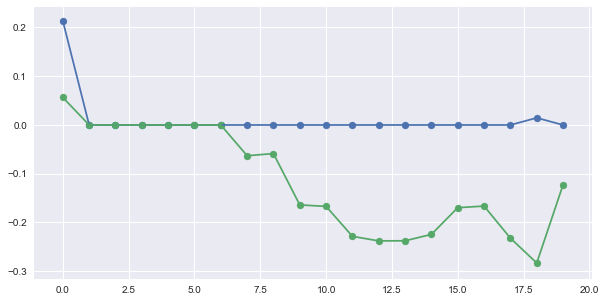

In [865]:
#plt.plot(range(len(varkeep['inv_total_contests'])), varkeep['inv_total_contests'])
#plt.scatter(range(len(varkeep['inv_total_contests'])), varkeep['inv_total_contests'])
#plt.plot(range(len(varkeep['tanh_n_contest'])), varkeep['tanh_n_contest'])
#plt.scatter(range(len(varkeep['tanh_n_contest'])), varkeep['tanh_n_contest'])
#plt.plot(range(len(varkeep['inv_rank'])), varkeep['inv_rank'])
#plt.scatter(range(len(varkeep['inv_rank'])), varkeep['inv_rank'])
#plt.plot(range(len(varkeep['exp_performance'])), varkeep['exp_performance'])
#plt.scatter(range(len(varkeep['exp_performance'])), varkeep['exp_performance'])
plt.plot(range(len(varkeep['tanh_smoothed_3months'])), varkeep['tanh_smoothed_3months'])
plt.scatter(range(len(varkeep['tanh_smoothed_3months'])), varkeep['tanh_smoothed_3months'])
plt.plot(range(len(varkeep['tanh_oldrating'])), varkeep['tanh_oldrating'])
plt.scatter(range(len(varkeep['tanh_oldrating'])), varkeep['tanh_oldrating'])

###  Plot all predictions

0.368760431566
0.428121110961
0.426883943739
0.463092170249
0.473472941356
0.443361434884
0.33829824064
0.220965844385
0.178817892694
0.165737878454
0.163039677338
0.161125774363
0.176068065615
0.16899712045
0.157968136594
0.16369542396
0.186635322735
0.203877169534
0.231199537353
0.193359437676


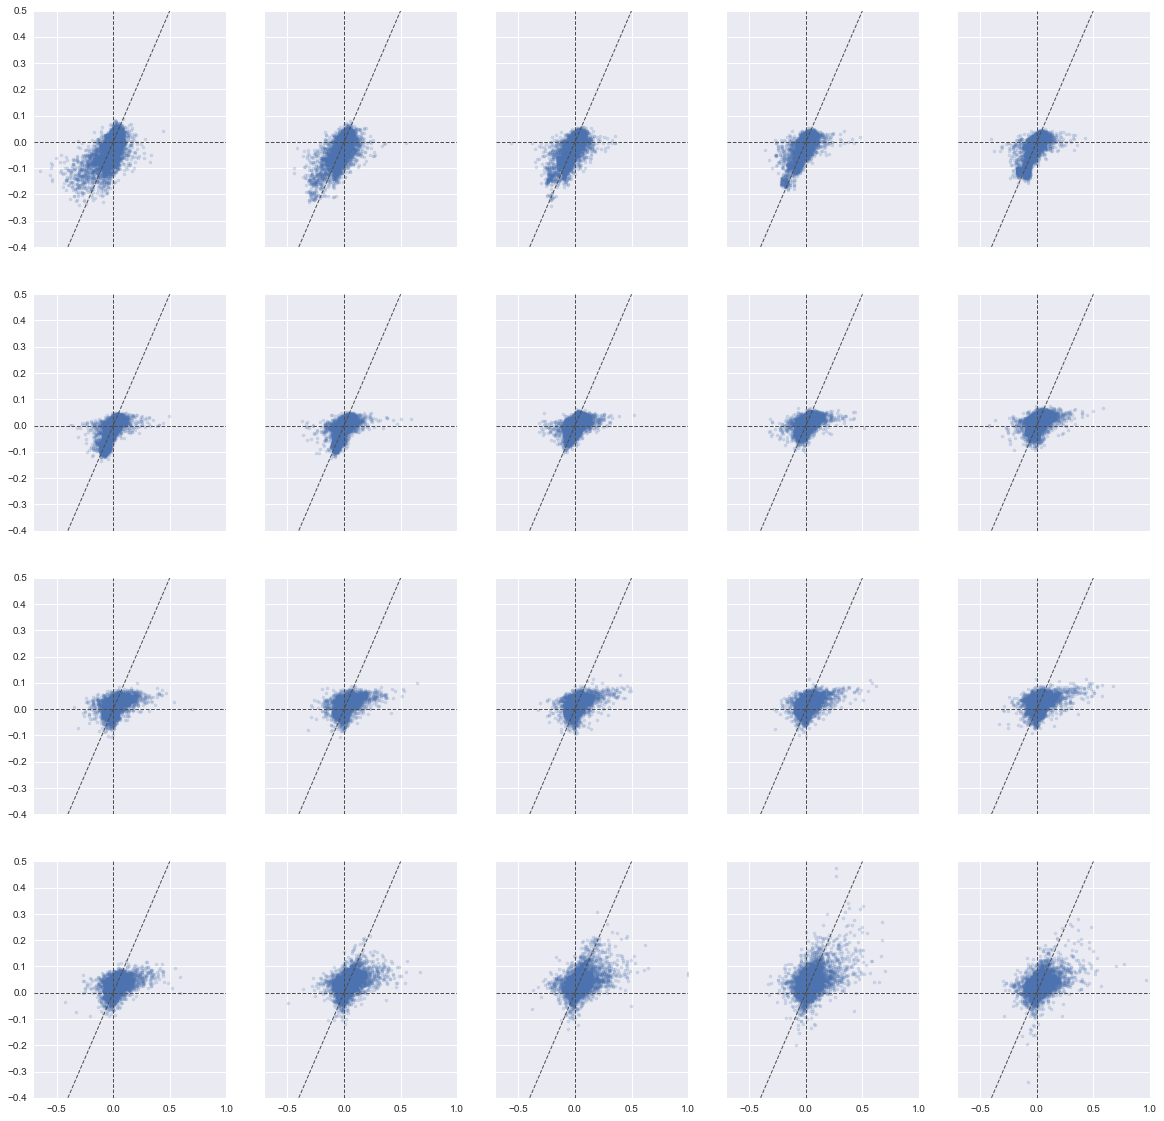

In [1042]:
#testidx = 1
plt.rcParams['figure.figsize'] = (20, 20)
f, axes = plt.subplots(len(models1)/5, 5, sharex='col', sharey='row')
with sns.color_palette("RdBu", len(models1)):
    for testidx in range(len(models1)):
        m = models1[testidx]
        ypred_test = m.predict(xtest_in[testidx])

        #plt.scatter(ytest_in[testidx], ypred_test, alpha=.2, s=10)
        ax = axes[testidx/5][testidx%5]
        ax.scatter(ytest_in[testidx], ypred_test, alpha=.2, s=10)
        print r2_score(ytest_in[testidx], ypred_test)
        ax.set_xlim([-.7, 1])
        ax.set_ylim([-.4, .5])
        #ax = plt.gca()
        diag = max(ax.get_xlim(), ax.get_ylim())
        ax.plot(diag, diag, linewidth=1, ls="--", c=".3")
        ax.plot([0,0], ax.get_ylim(), linewidth=1, ls="--", c=".3")
        ax.plot(ax.get_xlim(), [0,0], linewidth=1, ls="--", c=".3")

#plt.xlabel('Actual')
#plt.ylabel('Predicted')


## Export model

In [1091]:
# a list of all the bins
bins = map(int, qbins * 3739)

# a list of all the variables
variables = varkeep.columns.values

# normalization variables
xmax = np.max(allXnorm, axis=0)
xmax = xmax[variables]

# a dataframe of all coefficients for each model
df_coef = varkeep
df_coef['binlow'] = bins[0:-1]
df_coef['binhigh'] = bins[1:len(bins)]

# normalization vectors

out = dict(
    bins = bins,
    xmax = xmax,
    df_coef = df_coef,
    variables = variables,
    models = models1
)

import pickle
with open('ols_models_final.pickle', 'w') as f:
    pickle.dump(out, f)

#np.logical_and(df_coef['binlow'] <= 1500, df_coef['binhigh'] >= 1500)

In [995]:
sig_colnames

[('std_probability_contest', 0.014659149125143291),
 ('mean_probability_practice', 0.016216497458535591),
 ('time_between_mean', 0.017864108863562194),
 ('unique_tags_total', 0.018325147608321185),
 ('inv_total_wrong_contest', 0.020991527653230601),
 ('tanh_max_probability_contest', 0.021129708515660619),
 ('smoothed_3months', 0.021624580548067256),
 ('tanh_total_problems', 0.022811782942245604),
 ('tanh_rating_diff_mean', 0.033679599210080111),
 ('tanh_dp', 0.039445175954186361),
 ('inv_n_contest', 0.049196992629722165),
 ('inv_mean_wrong_contest', 0.04955267408343917),
 ('tanh_oldrating', 0.056459021229284492),
 ('tanh_rating_diff_std', 0.064519298532818847),
 ('tanh_user_rating', 0.074857308798759514),
 ('exp_performance', 0.083196020315523964),
 ('inv_rank', 0.15831729059066132),
 ('tanh_n_contest', 0.2012878568876578),
 ('tanh_smoothed_3months', 0.21361414508116955),
 ('inv_total_contests', 0.68308909158628706)]

In [ ]:
testidx = 19
m = models2[testidx]
ypred_test = m.predict(xtest_in[testidx])

plt.scatter(ytest_in[testidx], ypred_test, alpha=.5, s=5)
print r2_score(ytest_in[testidx], ypred_test)
ax = plt.gca()
diag = max(ax.get_xlim(), ax.get_ylim())
ax.plot(diag, diag, ls="--", c=".3")
ax.plot([0,0], ax.get_ylim(), ls="--", c=".3")
ax.plot(ax.get_xlim(), [0,0], ls="--", c=".3")
plt.xlabel('Actual')
plt.ylabel('Predicted')

# use elastic net instead of elasticnetCV

ultimately this doesn't work as well as with CV

In [481]:
cols = [x for x in Xtrain.columns.values if x not in ["yval", "q"]]
cols = np.array(cols)[param_idx]

In [495]:
q2, qbins2 = pd.qcut(allXnorm.smoothed_3months, 10, retbins=True)
allXnorm['q2'] = q2

In [548]:
Xtrain = allXnorm.loc[settrain + setval]
Xtest = allXnorm.loc[settest]

### try to fit the entire data set with a single linear model (not piecewise)

In [ ]:
ytrainall = Xtrain['yval']
xtrainall = Xtrain.drop(['yval', 'q', 'q2'], axis=1)

In [534]:
xtrainall_cols = xtrainall.columns
xtrainall = np.array(xtrainall)

In [535]:
xmax = np.max(xtrainall, axis=0)

In [536]:
xtrainall /= xmax

In [537]:
xtrainall[np.isnan(xtrainall)] = 0

In [540]:
xtestall = Xtest[xtrainall_cols]

In [ ]:
xtestall = np.array(xtestall)

In [538]:
en = ElasticNet(
    alpha=.00001,
    l1_ratio=.5,
    fit_intercept=False,
)
results = en.fit(xtrainall, ytrainall)

In [539]:
results.score(xtrainall, ytrainall)

0.2385168189099196

### Fit piecewise model with elasticnet

In [545]:
xmax = np.max(allXnorm[xtrainall_cols])

In [551]:
models2 = []
xtrain_in = []
ytrain_in = []
cnt = 0
for k, xin in Xtrain.groupby('q2'):
    xin.is_copy = False

    yin = xin['yval']
    xin = np.array(xin[xtrainall_cols])
    xin /= xmax
    xin[np.isnan(xin)] = 0
    xtrain_in.append(xin)
    ytrain_in.append(yin)
    
    en = ElasticNet(
        alpha=.001,
        l1_ratio=.5,
        fit_intercept=False,
    )
    results = en.fit(xin, yin)
    models2.append(results)
    nvar = sum(results.coef_ != 0)
    rsq = results.score(xin, yin)
    print k, "%6d entries, ---------------> %f, %d variables" %(xin.shape[0], rsq, nvar)

(0.033, 0.335]  32144 entries, ---------------> 0.314885, 21 variables
(0.335, 0.359]  32177 entries, ---------------> 0.390352, 19 variables
(0.359, 0.375]  32429 entries, ---------------> 0.434349, 19 variables
(0.375, 0.391]  32565 entries, ---------------> 0.249399, 24 variables
(0.391, 0.409]  32453 entries, ---------------> 0.144475, 20 variables
(0.409, 0.427]  32697 entries, ---------------> 0.128425, 23 variables
(0.427, 0.447]  32310 entries, ---------------> 0.108661, 22 variables
(0.447, 0.471]  32616 entries, ---------------> 0.106386, 24 variables
(0.471, 0.52]  33578 entries, ---------------> 0.152887, 29 variables
(0.52, 1.0]  33453 entries, ---------------> 0.141792, 33 variables


In [553]:
xtest_in = []
ytest_in = []
for k, xin in Xtest.groupby('q2'):
    xin.is_copy = False

    yin = xin['yval']
    xin = np.array(xin[xtrainall_cols])
    xin /= xmax
    xin[np.isnan(xin)] = 0
    xtest_in.append(xin)
    ytest_in.append(yin)

[0.31210291614780972, 0.39505872087826532, 0.42554525531034471, 0.25526278059221363, 0.14763866186975938, 0.12655056065470605, 0.11784258805781356, 0.10634407908443544, 0.14668997154366759, 0.1373540811637487]


(0, 0.5)

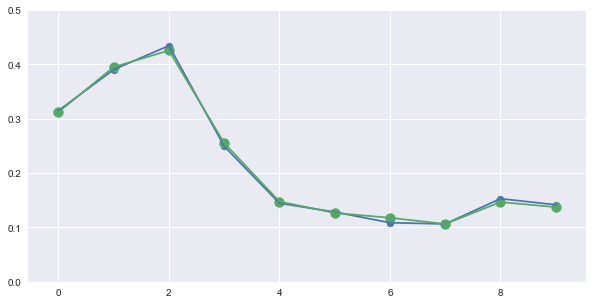

In [619]:
r2_train = []
r2_test = []
for i in range(len(models2)):
    m = models2[i]
    ypred_train = m.predict(xtrain_in[i])
    ypred_test = m.predict(xtest_in[i])
    r2_train.append(r2_score(ytrain_in[i], ypred_train))
    r2_test.append(r2_score(ytest_in[i], ypred_test))
print r2_test
plt.plot(r2_train)
plt.scatter(range(len(r2_train)), r2_train)
plt.plot(r2_test)
plt.scatter(range(len(r2_test)), r2_test, s=100)
plt.ylim(0, .5)

In [563]:
import pickle
with open('ols_models2.pickle', 'w') as f:
    pickle.dump(models2, f)

In [564]:
with open('ols_models2.pickle', 'r') as f:
    modelstest = pickle.load(f)

In [617]:
xtrainall_cols[param_idx][33]

'inv_total_contests'

(10, 48)


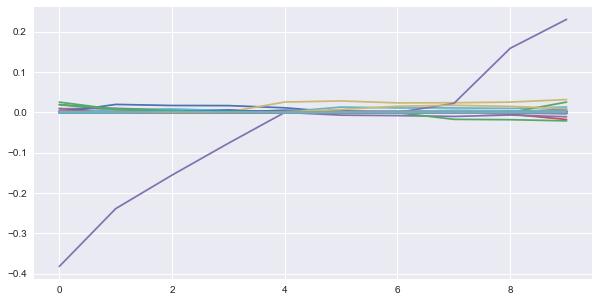

In [620]:
param_idx = np.zeros( xtrain_in[0].shape[1] )
for i in range(len(models2)):
    m = models2[i]
    param_idx += (m.coef_ > 0)
param_idx = param_idx > 0

mat = np.zeros( [len(models2), sum(param_idx > 0) ] )
print mat.shape

for i in range(len(models2)):
    m = models2[i]
    mat[i, :] = m.coef_[param_idx]
plt.plot(range(mat.shape[0]), mat)

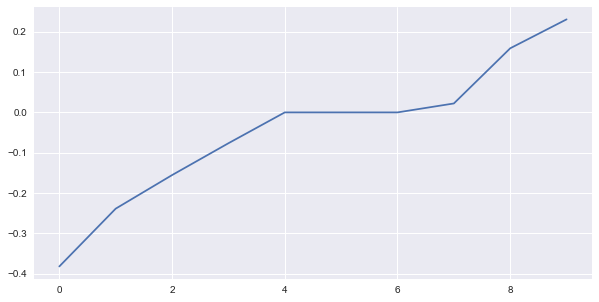

In [612]:
plt.plot(range(mat.shape[0]), mat[:,33])


In [635]:
cols = [x for x in Xtrain.columns.values if x not in ["yval", "q", "q2"]]
cols = np.array(cols)[param_idx]
coefs = models2[3].coef_[param_idx]
for n, c in zip(cols, coefs):
    print "%50s: %f" % (n, c)

                                          lowlevel: 0.002549
                           max_probability_contest: 0.000000
                                 unique_tags_total: 0.000000
                                 time_between_mean: 0.003869
                      log_std_probability_practice: 0.000000
                                      exp_lowlevel: 0.000362
                       exp_max_probability_contest: 0.006093
                      exp_max_probability_practice: 0.000000
                     exp_mean_probability_practice: 0.000000
                                     tanh_lowlevel: 0.000000
                    tanh_mean_probability_practice: -0.000000
                      tanh_std_probability_contest: 0.004396
                            tanh_unique_tags_total: 0.016825
                            tanh_time_between_mean: 0.000573
                             tanh_time_between_std: 0.000000
                                  tanh_user_rating: 0.000000
                  tanh_

In [640]:
model2_variables = list(cols)

#  Adding 2nd order interactions
Ultimately this adds a lot of complexity but not performance to the model

In [666]:
Xtrain2 = Xtrain[model2_variables]
Ytrain2 = Xtrain[['yval', 'q2']]
Xtest2 = Xtest[model2_variables]
Ytest2 = Xtest[['yval', 'q2']]

In [648]:
pf = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

In [685]:
xmax2 = np.max( np.array(Xtrain[model2_variables]) , axis=0 )

In [667]:
# put yval and q back in
Xtrain2.is_copy = False
Xtest2.is_copy = False
Xtrain2['yval'] = Ytrain2['yval']
Xtrain2['q2'] = Ytrain2['q2']
Xtest2['yval'] = Ytest2['yval']
Xtest2['q2'] = Ytest2['q2']

In [677]:
print xin.shape
print Xtrain2.shape

(33453, 1224)
(326422, 50)
